# **Statistics for Angle to ablation timelapse**

*(A2A_Tmlps_Stats) by Stephane Verger*

This notebook was made to propose a simple and reproducible way to plot and analyze the data from the "MT Angle2Ablation workflow".

It can be used with no prior knowledge of python programming. However it can be useful to acquire a little bit of background on how to use this tool. We recommand the very useful lecture series on BioImage Analysis from Robert Haase (https://www.youtube.com/playlist?list=PL5ESQNfM5lc7SAMstEu082ivW4BDMvd0U), in particular the lectures 9 to 11 about the use of python for data analysis and hypothesis testing.

## **How to run the code?**

**To run a cell containing code simply select it and hit enter+shift. Run each cell one by one while carefully following the instructions between each cell**

Briefly, there are 4 steps:
1. Load the required packages and functions.
2. Upload the data.
3. Generate the table and graph output with interactive widgets.
4. Save the desired output.

**1. Loading libraries**

Here, simply select the cell below, hit enter+shift to run the cell (load the packages) and continue to the next step.

In [1]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, fixed
from IPython.display import display
from ipyfilechooser import FileChooser

**2. Data upload**
1. Run the cell below.
2. Then, click on the "Upload" button and select the file to be analyzed.
3. Load the data to the notebook, by **running either** the cell call "#For Binder" (if you are running the notebook on binder) or "#For local install" if you are running it on you machine.

In [2]:
#Widget to upload data
uploader = widgets.FileUpload(
    accept='.txt',
    multiple=False
)
display(uploader)

FileUpload(value={}, accept='.txt', description='Upload')

For binder

In [ ]:
#For binder
#Data upload and read
uploaded_file = list(uploader.value)[0]
all_data = pd.read_csv(io.BytesIO(uploaded_file['content']), sep = "\t")

For local install

In [ ]:
#For local install
#Data upload and read
uploaded_file = list(uploader.value.values())[0]
all_data = pd.read_csv(io.BytesIO(uploaded_file['content']), sep = "\t")

**3. Graphs and tables**
1. Run the cell below.
2. Then scroll down and to see the output and widget interaction.

You can select which genotype data are displayed (Click + shith or ctrl to select multiple), whether average per genotype or samples, or individual cells are displayed, and whether to show the output for the angle or anisotropy values.

In [4]:

#Message
print('Warning: It is not possible to select "show individual samples" = No and "Show induvidual cells" = Yes at the same time.')
print('Currently the table generation only supports the selection of multiple genotypes when "show individual samples" and "cells" = No.')
print('Alternatively the "individual sample" data table can be shown if only one genotype is selected at a time.')
print('\nClick + shith or ctrl to select multiple genotypes.')
print('To change and fix the x axis limit of the plot to a defined value, select a value different from zero in the x axis limit widget.') 

#Widgets
#Get groups of genotypes/conditions
GenoGroup = all_data.groupby(['Genotype/condition'])
GenoGroupKeys = list(GenoGroup.groups.keys())
#style for menus
style = {'description_width': 'initial'}
#Widget select multiple menu to choose genotype to plot, toggle to show individual samples, cells and choose between angle and anisotropy
SelectGeno= widgets.SelectMultiple(options=GenoGroupKeys, value=[GenoGroupKeys[0]], description='Genotype/condition to plot.', disabled=False, style=style, rows=len(GenoGroupKeys), layout={'width': 'max-content'})
ShowSamples = widgets.ToggleButtons(options=[('No', False), ('Yes', 'Genotype/condition')], value=False, description='Show individual samples', button_style='', style=style)
ShowCells = widgets.ToggleButtons(options=[('No', False), ('Yes', 'Sample Number')], value=False, description='Show individual cells', button_style='', style=style)
ChooseValue = widgets.ToggleButtons(options=[('Angle to ablation', 'Acute absolute angle to ablation'), ('Anisotropy', 'Anisotropy')], value='Acute absolute angle to ablation', description='Value to plot', button_style='', style=style)
ChooseXlim = widgets.FloatText(value=0, description='X axis limit', disabled=False, style=style)

#Function to define the timelapse graph
def datagraph(whichdata, col, row, ydata, Xlim, save, path):
    

    #subsets data to be shown in plot
    subdata = all_data[all_data['Genotype/condition'].isin(whichdata)]
    #Display more or less details from genotype to individual cells
    if (ShowSamples.value==False and ShowCells.value==False):
        huedata = 'Genotype/condition'
        tograph = True
        totable = True
    elif (ShowSamples.value=='Genotype/condition' and ShowCells.value==False):
        huedata = 'Sample Number'
        tograph = True
        totable = True
    elif (ShowSamples.value=='Genotype/condition' and ShowCells.value=='Sample Number'):
        huedata = 'CellNumber'
        tograph = True
        totable = False
    elif (ShowSamples.value==False and ShowCells.value=='Sample Number'):
        huedata = 'CellNumber'
        tograph = False
        totable = False
    if (len(SelectGeno.value) > 1 and ShowSamples.value=='Genotype/condition'):
        totable = False
    #plot
    if (tograph==True):
        fig = sns.relplot(data=subdata, col=col, row=row,  x="Timepoint", y=ydata, hue=huedata, errorbar=('ci', 95), kind="line")
        if (Xlim>0):
            fig.set(ylim=(0, Xlim))
    
    #Table
    if (totable==True):
        #subsets data to be shown in table
        SubGenoTimeGroup = subdata.groupby([huedata, 'Timepoint'], as_index=False)
        #Aggregate with mean and Bootstraped 95 CI
        MeanSGTG = SubGenoTimeGroup[ydata].agg(np.mean).round(3)
        BtstrpSGTG = SubGenoTimeGroup[ydata].agg(lambda x: sns.utils.ci(sns.algorithms.bootstrap(x, func=np.mean, n_boot=1000, units=None))[1]-(np.mean(x))).round(3)
        #Pivot, merged and display timeseries table
        pivMeanSGTG = MeanSGTG.pivot(index=huedata, columns='Timepoint', values=ydata)
        pivBtstrpSGTG = BtstrpSGTG.pivot(index=huedata, columns='Timepoint', values=ydata)
        Finaltable = pivMeanSGTG.astype('string') + ' +- ' + pivBtstrpSGTG.astype('string')
        print('\n\n The data displayed in both table and graph is the mean values +- bootstrapped 95% confidence interval')
        display(Finaltable) 
    
    #Save table and plot
    if (save == True):
        if (totable==True):
            Finaltable.to_csv(path + '.csv')
        if (tograph==True):
            plt.savefig(path + '.svg')
    
#Interact widget
DataGraphWidget = widgets.interactive(datagraph, whichdata=SelectGeno, col=ShowSamples, row=ShowCells, ydata=ChooseValue, Xlim = ChooseXlim, save = fixed(False), path = fixed(False));
DataGraphWidget


Currently the table generation only supports the selection of multiple genotypes when "show individual samples" and "cells" = No.
Alternatively the "individual sample" data table can be shown if only one genotype is selected at a time.

Click + shith or ctrl to select multiple genotypes.
To change and fix the x axis limit of the plot to a defined value, select a value different from zero in the x axis limit widget.


interactive(children=(SelectMultiple(description='Genotype/condition to plot.', index=(0,), layout=Layout(widt…

**4. Save data and graphs**
1. Run the next two cells below.
2. Click on the "Select" button and select a destination folder as well as an output file name (e.g. GFP-MBD_Angles).
Avoid spaces and special characters in the name.
3. Validate by clicking "Select" again. This should display in green the destination path with file name.
4. Finally, run the last cell. This will directly save the table as a .csv file and the graph as a .svg file with the choosen file name in the selected destination folder.

Note that you can go back and forth between the interactive widgets and display above, and this save step, but you will have to reload the first cell below everytime before saving to get the current status of the table and graphs diplayed, and you may need to change the output file name, before running the last cell to save.

The .csv file can be opened in any text and spreadsheet editor. The .svg file can be opened and further modified (e.g. to change the time point naming) with any vector graphic editor (e.g. Inkscape or Illustrator). 

In [4]:
#Retrieve selected value from interactive widget
whichdata = DataGraphWidget.children[0].value
col = DataGraphWidget.children[1].value
row = DataGraphWidget.children[2].value
ydata = DataGraphWidget.children[3].value
Xlim = DataGraphWidget.children[4].value

In [5]:
#FileChooser
starting_directory = '/' #replace with e.g. C:\ for windows. For mac go to, /Users/..., for linux, /home/...
chooser = FileChooser(starting_directory)

#Display
print('Suggested output filename content: ' + str(whichdata) + ', ' + str(ydata))
display(chooser)

Suggested output filename content: ('mCit-MBD',), Acute absolute angle to ablation


FileChooser(path='/', filename='', title='', show_hidden=False, select_desc='Select', change_desc='Change', se…

Saved table below as .csv file and graph as .svg file


 The data displayed in both table and graph is the mean values +- bootstrapped 95% confidence interval


Timepoint,1,2,3,4,5,6,7,8,9,10,11,12,13
Sample Number,,,,,,,,,,,,,
1,40.288 +- 18.534,38.307 +- 19.237,27.122 +- 15.649,26.07 +- 17.029,25.568 +- 16.185,22.774 +- 18.893,22.49 +- 19.318,20.831 +- 21.721,19.497 +- 21.709,19.788 +- 21.349,20.522 +- 20.666,19.893 +- 20.753,21.174 +- 18.967
2,36.811 +- 18.191,35.525 +- 18.435,36.895 +- 18.648,36.256 +- 18.035,38.196 +- 22.688,41.876 +- 17.356,38.933 +- 18.446,36.673 +- 17.115,34.904 +- 18.709,32.672 +- 16.024,29.479 +- 14.841,27.295 +- 15.401,29.306 +- 13.024
3,24.066 +- 13.706,27.439 +- 9.48,24.982 +- 10.176,21.63 +- 10.251,23.521 +- 8.591,22.798 +- 9.232,22.338 +- 9.128,22.312 +- 9.084,22.633 +- 7.877,24.108 +- 8.438,24.473 +- 7.77,24.926 +- 8.951,25.497 +- 9.381
4,28.739 +- 10.489,30.989 +- 11.251,27.758 +- 11.536,25.677 +- 10.188,29.647 +- 16.037,27.867 +- 11.573,25.811 +- 10.791,26.318 +- 10.441,25.671 +- 8.007,27.81 +- 7.381,29.189 +- 7.729,28.475 +- 9.61,30.125 +- 9.263
5,53.871 +- 19.005,38.404 +- 14.801,36.207 +- 12.529,25.52 +- 10.426,20.897 +- 12.299,25.812 +- 11.036,15.947 +- 6.637,10.63 +- 6.224,13.602 +- 8.058,11.108 +- 6.044,12.862 +- 6.383,21.444 +- 15.239,14.423 +- 8.738
6,50.198 +- 13.966,44.377 +- 14.407,32.09 +- 18.305,29.63 +- 17.996,27.547 +- 14.641,28.579 +- 15.356,29.114 +- 14.118,27.455 +- 12.669,25.739 +- 12.344,23.959 +- 11.953,22.961 +- 11.382,23.719 +- 11.012,22.677 +- 11.843
7,31.946 +- 27.392,28.756 +- 23.616,32.849 +- 20.741,35.69 +- 22.502,38.002 +- 21.112,39.046 +- 19.425,37.616 +- 19.685,34.678 +- 14.525,36.282 +- 19.634,39.504 +- 20.498,38.101 +- 20.544,41.769 +- 24.9,41.738 +- 27.571
8,59.833 +- 10.219,56.319 +- 13.409,52.955 +- 13.132,51.015 +- 12.991,47.478 +- 15.537,45.23 +- 15.453,45.293 +- 14.71,43.32 +- 14.817,42.246 +- 13.446,41.129 +- 13.049,35.603 +- 13.858,32.747 +- 12.887,33.238 +- 15.206
9,39.101 +- 21.752,29.413 +- 12.456,22.854 +- 9.306,24.223 +- 11.424,21.438 +- 11.436,18.308 +- 8.444,20.86 +- 8.481,21.442 +- 8.197,22.88 +- 10.623,24.492 +- 12.098,22.787 +- 11.033,19.745 +- 11.74,23.373 +- 11.328


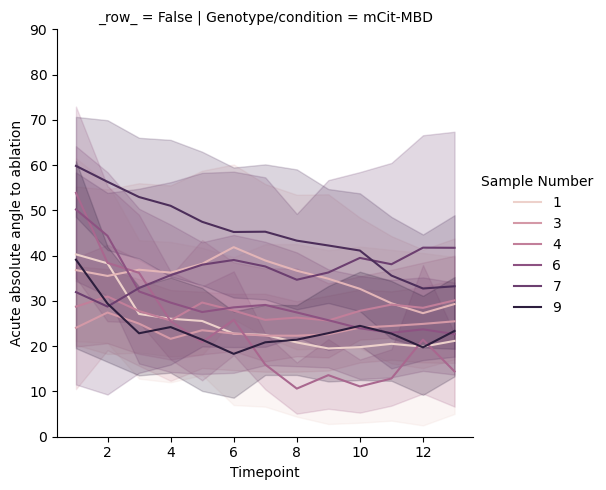

In [6]:
print ('Saved table below as .csv file and graph as .svg file')
Path = chooser.selected
datagraph(whichdata, col, row, ydata, Xlim, True, Path)